In [6]:
# Extra code voor aanvullende test die bekijken welke cyclische groepen voor de eerste 49 priemgetallen bestaan waarvoor alle 
# F_q primitive points double generators zijn.
import pandas as pd
from sympy import primerange

# Laad CSV-bestand
df = pd.read_csv("Alle cyclische groepen (1st 49 primes) waarvoor alle prim points double gen. zijn .csv")

# Zorg dat je de juiste kolom pakt (bijv. "q" of iets anders als dat de kolomnaam is)
eerste_kolom = df["q"].dropna().astype(int).unique().tolist()
# Genereer eerste 49 priemgetallen
eerste_49_priemen = list(primerange(2, 230))[:49]

# Bepaal welke priemgetallen ontbreken
ontbrekend = sorted(set(eerste_49_priemen) - set(eerste_kolom))

print("Ontbrekende priemgetallen:", ontbrekend)


Ontbrekende priemgetallen: [2, 23, 47, 59, 71, 83, 107, 109, 113, 131, 139, 149, 167, 179, 191, 199, 227]


In [2]:
# Deze code geeft alle informatie voor de groepen E_a(\F_541) . Het komt overeen met het 
# tabblad "DEF. Double points check 2th 50"
from sage.all import prime_range, FiniteField, EllipticCurve
import csv

# Functie voor het toevoegen van twee punten P en Q op de elliptische kromme
def add_points(P, Q, E, a):
    if P.is_zero():
        return Q
    if Q.is_zero():
        return P
    if P == Q:  # Puntverdubbeling
        if P[1] == 0:
            return E(0)
        lam = (3 * P[0]^2 + a) / (2 * P[1])
        nu = (-P[0]^3 + a * P[0]) / (2 * P[1])
    elif P[0] == Q[0]:
        return E(0)
    else:
        lam = (Q[1] - P[1]) / (Q[0] - P[0])
        nu = (P[1] * Q[0] - Q[1] * P[0]) / (Q[0] - P[0])

    x3 = lam^2 - P[0] - Q[0]
    y3 = (-lam * x3) - nu
    return E(x3, y3)

# Functie om de orde van een punt te bepalen
def element_order(P, E, a):
    if P.is_zero():
        return 1
    current_point = P
    for m in range(1, E.order() + 1):
        if current_point.is_zero():
            return m
        current_point = add_points(current_point, P, E, a)
    return None

# Functie om te checken of element primitief is in F_q^*
def is_primitive(x, q):
    if x == 0:
        return False
    return x.multiplicative_order() == q - 1

# Functie om info per kromme te verzamelen
def analyze_curve(q, a):
    F = FiniteField(q)
    try:
        E = EllipticCurve(F, [0, 0, 0, a, 0])

        if E.is_singular():
            return (q, a, None, "Singulier", [], [], [], False, False)

        group_order = E.order()
        cyclic = False
        generators = []

        # Verzamel alle punten en categoriseer ze
        primitive_points = []
        all_points = E.points()

        for P in all_points:
            if P.is_zero():
                continue
            if is_primitive(P[0], q) and is_primitive(P[1], q):
                primitive_points.append((P[0], P[1]))

            ordP = element_order(P, E, a)
            if ordP == group_order:
                cyclic = True
                generators.append((P[0], P[1]))

        # Dubbelpunten: punten die zowel generator als primitief zijn
        generator_set = set(generators)
        primitive_set = set(primitive_points)
        double_points = list(generator_set.intersection(primitive_set))

        # Controleer volledige gelijkheid
        all_primitives_are_double = primitive_set.issubset(generator_set)
        all_generators_are_double = generator_set.issubset(primitive_set)

        return (q, a, group_order, "Ja" if cyclic else "Nee",
                generators, primitive_points, double_points,
                all_primitives_are_double, all_generators_are_double)
        
    except ArithmeticError:
        return (q, a, None, "Singulier", [], [], [], False, False)

# --------------------------

# --------------------------

primes = list(prime_range(541, 547))  

results = []

for q in primes:
    F = FiniteField(q)
    print(f"Bezig met q = {q}...")
    for a in F:
        if a == 0:
            continue
        result = analyze_curve(q, a)
        results.append(result)

# --------------------------
# Print grote samenvattende tabel
# --------------------------

print("\n\n--- Grote samenvattende tabel ---")
print("q\ta\tOrde groep\tCyclisch\tGenerators\tPrimitive punten\tDubbelpunten\tAlle primitives dubbel?\tAlle generators dubbel?")

for q, a, group_order, cyclic, gens, prims, doubles, all_prim_doubles, all_gen_doubles in results:
    if group_order is None:
        print(f"{q}\t{a}\tSingulier\t-\t-\t-\t-\t-\t-")
    else:
        gens_str = ", ".join([f"({x},{y})" for (x, y) in gens]) if gens else "-"
        prims_str = ", ".join([f"({x},{y})" for (x, y) in prims]) if prims else "-"
        doubles_str = ", ".join([f"({x},{y})" for (x, y) in doubles]) if doubles else "-"
        print(f"{q}\t{a}\t{group_order}\t{cyclic}\t{gens_str}\t{prims_str}\t{doubles_str}\t{all_prim_doubles}\t{all_gen_doubles}")

# --------------------------
# Exporteer resultaten naar CSV
# --------------------------

with open("elliptic_curves_summary_541_prime_extended.csv", "w", newline='') as csvfile:
    fieldnames = [
        'q', 'a', 'group_order', 'cyclisch',
        'generators', 'primitive_points', 'double_points',
        'all_primitives_are_double', 'all_generators_are_double'
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for q, a, group_order, cyclic, gens, prims, doubles, all_prim_doubles, all_gen_doubles in results:
        if group_order is None:
            writer.writerow({
                'q': q,
                'a': a,
                'group_order': "Singulier",
                'cyclisch': "-",
                'generators': "-",
                'primitive_points': "-",
                'double_points': "-",
                'all_primitives_are_double': "-",
                'all_generators_are_double': "-"
            })
        else:
            gens_str = "; ".join([f"({x},{y})" for (x, y) in gens]) if gens else "-"
            prims_str = "; ".join([f"({x},{y})" for (x, y) in prims]) if prims else "-"
            doubles_str = "; ".join([f"({x},{y})" for (x, y) in doubles]) if doubles else "-"
            writer.writerow({
                'q': q,
                'a': a,
                'group_order': group_order,
                'cyclisch': cyclic,
                'generators': gens_str,
                'primitive_points': prims_str,
                'double_points': doubles_str,
                'all_primitives_are_double': all_prim_doubles,
                'all_generators_are_double': all_gen_doubles
            })

print("\n✅ CSV-bestand 'elliptic_curves_summary_541_prime_extended.csv' succesvol aangemaakt!")


Bezig met q = 541...


--- Grote samenvattende tabel ---
q	a	Orde groep	Cyclisch	Generators	Primitive punten	Dubbelpunten	Alle primitives dubbel?	Alle generators dubbel?
541	1	500	Nee	-	(18,127), (18,414), (107,113), (107,428), (181,258), (181,283), (250,107), (250,434), (261,267), (261,274), (282,40), (282,501), (318,13), (318,528), (331,13), (331,528), (335,259), (335,282), (358,150), (358,391), (385,91), (385,450), (425,184), (425,357), (504,117), (504,424), (527,183), (527,358)	-	False	True
541	2	522	Nee	-	(2,114), (2,427), (55,197), (55,344), (86,114), (86,427), (131,223), (131,318), (195,150), (195,391), (218,40), (218,501), (321,99), (321,442), (388,158), (388,383), (389,163), (389,378), (403,248), (403,293), (409,10), (409,531), (434,199), (434,342), (442,62), (442,479), (474,127), (474,414)	-	False	True
541	3	500	Nee	-	(24,248), (24,293), (68,72), (68,469), (98,153), (98,388), (117,99), (117,442), (127,259), (127,282), (131,107), (131,434), (156,153), (156,388), (183,257), (18

In [3]:
#Deze code checkt of de condition uit conjecture 2.5.7 wordt voldaan voor de eerste 400 priemgetallen
from sage.all import *
import pandas as pd
import os
from datetime import datetime

def W(n):
    return len([d for d in divisors(n) if is_squarefree(d)])

# Eerste 400 priemgetallen, q > 2
primes = [p for p in primes_first_n(400) if p > 2]
resultaten = []

for q in primes:
    Fq = GF(q)
    W_q1 = W(q - 1)
    W_q1div2 = W((q - 1) // 2) if (q - 1) % 2 == 0 else 0

    for a in Fq:
        if a == 0:
            continue
        try:
            # y^2 = x^3 + ax (coëfficiëntenvorm [0, 0, 0, a, 0])
            E = EllipticCurve(Fq, [0, 0, 0, a, 0])
            N = E.cardinality()
            W_N = W(N)
            lhs = sqrt(q)
            rhs = 4 * W_q1 * W_q1div2 * W_N
            resultaat = bool(lhs > rhs)
            resultaten.append({
                "q": q,
                "a": int(a),
                "N": N,
                "W(q-1)": W_q1,
                "W((q-1)/2)": W_q1div2,
                "W(N)": W_N,
                "q^(1/2) > 4*W(q-1)*W((q-1)/2)*W(N)": resultaat
            })
        except Exception as e:
            print(f"⚠️ Fout bij q={q}, a={a}: {e}")
            continue

# Exportbestand naar bureaublad
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
bestandsnaam = f"elliptic_check_400_{timestamp}.csv"
pad = os.path.join(os.path.expanduser("~"), "Desktop", bestandsnaam)

df = pd.DataFrame(resultaten)
df.to_csv(pad, index=False)

print(f"✅ Bestand succesvol opgeslagen op bureaublad als: {bestandsnaam}")


✅ Bestand succesvol opgeslagen op bureaublad als: elliptic_check_400_20250603_221430.csv


In [ ]:
# Deze code test of er in de eerste 50 priemwaarden q ook q's zijn waarvoor voor elke a er een double generator is.
import pandas as pd

# Laad het Excel-bestand
df = pd.read_excel("Altijd_double_point.xlsx")

# Controleer per q of bij elke a de kolom 'double_points' niet leeg of '-' is
# We nemen aan dat '-' betekent: geen double point

per_q = df.groupby("q").apply(lambda group: all(group["double_points"] != "-"))

# Selecteer alleen de q's waar dit voor geldt
allemaal_double = per_q[per_q].index.tolist()

print(f"✅ Aantal priemgetallen waarvoor elke a minstens één double point oplevert: {len(allemaal_double)}")
print("Deze priemgetallen zijn:", allemaal_double)

In [14]:
# Deze code test of er in de tweede 50 priemwaarden q ook q's zijn waarvoor voor elke a er een double generator is.
import pandas as pd

# Laad het Excel-bestand
df = pd.read_excel("Altijd_double_point_2th.xlsx")

# Controleer per q of bij elke a de kolom 'double_points' niet leeg of '-' is
# We nemen aan dat '-' betekent: geen double point

per_q = df.groupby("q").apply(lambda group: all(group["double_points"] != "-"))

# Selecteer alleen de q's waar dit voor geldt
allemaal_double = per_q[per_q].index.tolist()

print(f"✅ Aantal priemgetallen waarvoor elke a minstens één double point oplevert: {len(allemaal_double)}")
print("Deze priemgetallen zijn:", allemaal_double)


✅ Aantal priemgetallen waarvoor elke a minstens één double point oplevert: 0
Deze priemgetallen zijn: []


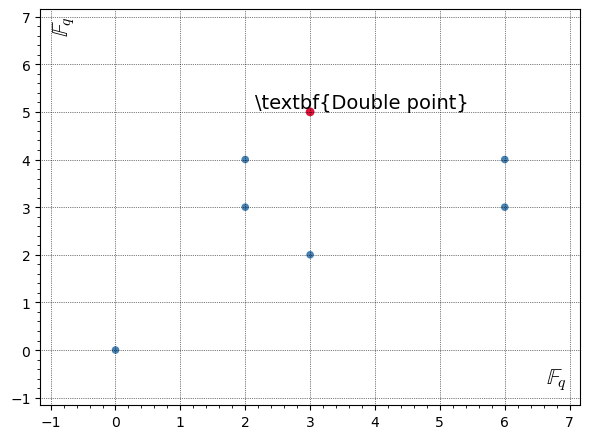

In [15]:
# Extra code om plaatje te maken, nog niet gebruikt.
# Definieer de punten
punten = [(0, 0), (2, 3), (2, 4), (3, 2), (3, 5), (6, 3), (6, 4)]

# Plot alle punten behalve de double point
gewone_punten = [p for p in punten if p != (3, 5)]
plot_gewone = sum([point(p, size=30, color='steelblue') for p in gewone_punten])

# Plot het speciale punt (3,5) in een contrasterende kleur
plot_special = point((3, 5), size=40, color='crimson')

# Annotatie bij het speciale punt
annotatie = text(r"\textbf{Double point}", (3.8, 5.2), fontsize=14, color='black')

# Assenlabels verder van het midden en in mooie stijl
assenlabels = (
    text(r"$\mathbb{F}_q$", (6.8, -0.6), fontsize=16, color='black') +
    text(r"$\mathbb{F}_q$", (-0.8, 6.8), rotation=90, fontsize=16, color='black')
)

# Combineer alles
plot = plot_gewone + plot_special + annotatie + assenlabels
plot.axes(False)  # Geen numerieke assen
plot.set_axes_range(xmin=-1, xmax=7, ymin=-1, ymax=7)
plot.show(gridlines=True, frame=True, figsize=6)


In [1]:
# Test voor singulariteit bij q=2 en q=3
for q in [2, 3]:
    print(f"\n--- Test voor F_{q} ---")
    F = GF(q)
    R.<x,y> = PolynomialRing(F)

    # Definieer de kromme E_0: y^2 = x^3 als projectieve kromme
    f = y^2 - x^3

    # Maak een algebraïsche kromme van deze vergelijking
    C = Curve(f)

    # Zoek singuliere punten
    sing = C.singular_points()
    
    # Output
    if sing:
        print(f"De kromme is singulier in punt(en): {sing}")
    else:
        print("De kromme is niet singulier.")



--- Test voor F_2 ---
De kromme is singulier in punt(en): [(0, 0)]

--- Test voor F_3 ---
De kromme is singulier in punt(en): [(0, 0)]
